In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class

from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [2]:
use_resid = False

if use_resid:
    # Load the residuals
    dataset_filename = '..\datasets\power_transitions_with_residuals.xlsx'
else:
    dataset_filename = '..\datasets\power_transitions.xlsx'

dataset_filename = '..\datasets\pt_sc_imputation_all_yr.xlsx'

dataset_PT = TSD(file_path=dataset_filename)
dataset_PT.scv = dataset_PT.scv.groupby('dataset').get_group('PT')
dataset_PT.scv_imputed = dataset_PT.scv_imputed.groupby('dataset').get_group('PT')

dataset_FULL = TSD(file_path=dataset_filename)
dataset_100y = TSD(file_path=dataset_filename)
dataset_100y.scv = dataset_100y.scv.groupby('dataset').get_group('100y')
dataset_100y.scv_imputed = dataset_100y.scv_imputed.groupby('dataset').get_group('100y')

polity_df = download_data("https://seshatdata.com/api/core/polities/")

Dataset loaded from ..\datasets\pt_sc_imputation_all_yr.xlsx
Dataset loaded from ..\datasets\pt_sc_imputation_all_yr.xlsx
Dataset loaded from ..\datasets\pt_sc_imputation_all_yr.xlsx
Downloaded 839 rows


In [3]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]
# columns to sum into crisis variable
crisis_keep = ['overturn', 'predecessor_assassination', 'intra_elite', 'military_revolt']
PT_mapping = {'PT_types':{}}
for c,col in enumerate(crisis_vars):
    if col in crisis_keep:
        PT_mapping['PT_types'][col] = 1
    dataset_PT.scv[col] = dataset_PT.raw[col]
    dataset_PT.scv_imputed[col] = dataset_PT.scv[col]

dataset_PT.scv['Crisis'] = dataset_PT.raw.apply(lambda row: weighted_mean(row, PT_mapping, "PT_types", imputation='remove'), axis=1)
dataset_PT.scv_imputed['Crisis'] = dataset_PT.scv['Crisis']
dataset_PT.scv['duration'] = dataset_PT.raw['duration']
dataset_PT.scv_imputed['duration'] = dataset_PT.scv['duration']


In [4]:
dataset_PT.scv_imputed["LastCrisis"] = 0
for index, row in dataset_PT.scv.iterrows():
    pol_id = row['PolityID']
    pol_end_year = polity_df.loc[polity_df['id'] == pol_id].end_year.values[0]
    last_crisis = abs(row.Year - pol_end_year) < 10
    dataset_PT.scv_imputed.at[index, "LastCrisis"] = last_crisis

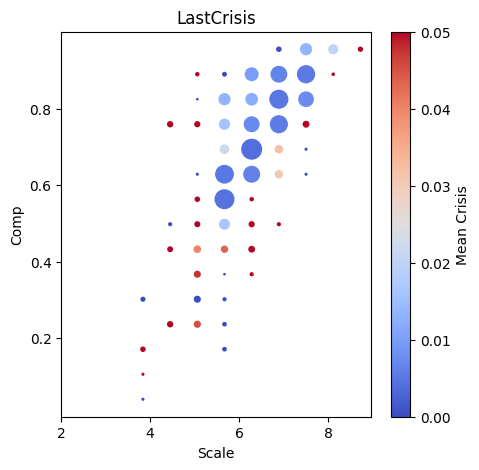

In [5]:
x_cols = ['Scale_1', 'Comp']
y_col = "LastCrisis"  # or set to the crisis variable you want to plot
Xy = dataset_PT.scv_imputed[[y_col] + x_cols].dropna()
x = Xy[x_cols[0]].values
y = Xy[x_cols[1]].values
z = Xy[y_col].values

grid_size = 15

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Define the grid
x_bins = np.linspace(0, 10, grid_size + 1)
y_bins = np.linspace(0, 1, grid_size + 1)

# Bin the data
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(), 'x'].mean(),
                        df.loc[df.x_bin == df.x_bin.max(), 'x'].mean(),
                        len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(), 'y'].mean(),
                        df.loc[df.y_bin == df.y_bin.max(), 'y'].mean(),
                        len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()
x, y = np.meshgrid(x_bins, y_bins)

fig, ax = plt.subplots(figsize=(5, 5))
sc = ax.scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm',
                s=counts.T.values.flatten() * 0.8, vmax=0.05)
ax.grid(False)
ax.set_title(y_col)
ax.set_xlabel('Scale')
ax.set_ylabel('Comp')
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticks([2, 4, 6, 8])
plt.colorbar(sc, ax=ax, label='Mean Crisis')
plt.show()

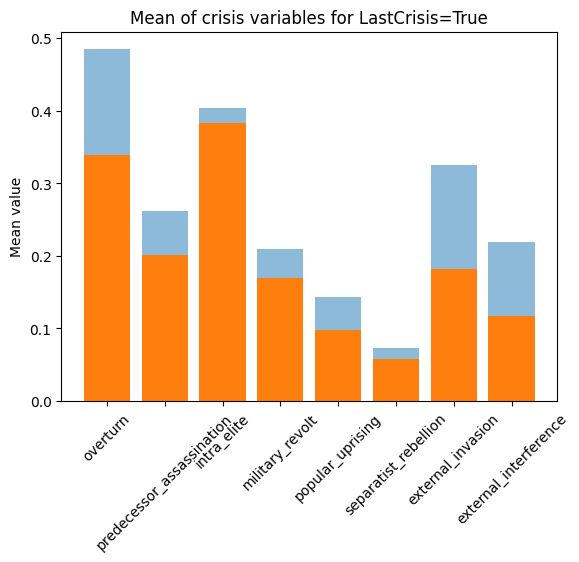

In [26]:
# Calculate the mean (or sum) of each crisis variable for rows where LastCrisis is True
end_crisis_means = dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed.LastCrisis, crisis_vars].mean()
crisis_means = dataset_PT.scv_imputed[crisis_vars].mean()
plt.bar(end_crisis_means.index, end_crisis_means.values, alpha=0.5)
plt.bar(crisis_means.index, crisis_means.values)

plt.ylabel('Mean value')
plt.title('Mean of crisis variables for LastCrisis=True')
plt.xticks(rotation=45)
plt.show()

In [4]:
dataset_100y = TSD(categories=['sc',"wf"], file_path="../datasets/100_yr_dataset.csv")

Dataset loaded from ../datasets\100_yr_dataset.xlsx
